<a href="https://colab.research.google.com/github/MJ199999/WaterPotability/blob/main/WaterQuality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dataprep

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
data = pd.read_csv("water_potability.csv")

In [ ]:
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [ ]:
# from dataprep.eda import create_report
# create_report(data)

In [4]:
# data2 = data.dropna(axis=0)
data2 = data

print(data2.isna().sum())

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


## Remove Outliers

In [29]:
norm_upper_limit = data["Sulfate"].mean() + 3 * data["Sulfate"].std()
norm_lower_limit = data["Sulfate"].mean() - 3 * data["Sulfate"].std()

data_new = data[(data["Sulfate"] > norm_lower_limit) & (data["Sulfate"] < norm_upper_limit)]


norm_upper_limit = data["ph"].mean() + 3 * data["ph"].std()
norm_lower_limit = data["ph"].mean() - 3 * data["ph"].std()

data_new = data[(data["ph"] > norm_lower_limit) & (data["ph"] < norm_upper_limit)]


norm_upper_limit = data["Trihalomethanes"].mean() + 3 * data["Trihalomethanes"].std()
norm_lower_limit = data["Trihalomethanes"].mean() - 3 * data["Trihalomethanes"].std()

data_new = data[(data["Trihalomethanes"] > norm_lower_limit) & (data["Trihalomethanes"] < norm_upper_limit)]


norm_upper_limit = data["Solids"].mean() + 3 * data["Solids"].std()
norm_lower_limit = data["Solids"].mean() - 3 * data["Solids"].std()

data_new = data[(data["Solids"] > norm_lower_limit) & (data["Solids"] < norm_upper_limit)]


norm_upper_limit = data["Chloramines"].mean() + 3 * data["Chloramines"].std()
norm_lower_limit = data["Chloramines"].mean() - 3 * data["Chloramines"].std()

data_new = data[(data["Chloramines"] > norm_lower_limit) & (data["Chloramines"] < norm_upper_limit)]


norm_upper_limit = data["Conductivity"].mean() + 3 * data["Conductivity"].std()
norm_lower_limit = data["Conductivity"].mean() - 3 * data["Conductivity"].std()

data_new = data[(data["Conductivity"] > norm_lower_limit) & (data["Conductivity"] < norm_upper_limit)]


norm_upper_limit = data["Organic_carbon"].mean() + 3 * data["Organic_carbon"].std()
norm_lower_limit = data["Organic_carbon"].mean() - 3 * data["Organic_carbon"].std()

data_new = data[(data["Organic_carbon"] > norm_lower_limit) & (data["Organic_carbon"] < norm_upper_limit)]


norm_upper_limit = data["Turbidity"].mean() + 3 * data["Turbidity"].std()
norm_lower_limit = data["Turbidity"].mean() - 3 * data["Turbidity"].std()

data_new = data[(data["Turbidity"] > norm_lower_limit) & (data["Turbidity"] < norm_upper_limit)]


norm_upper_limit = data["Hardness"].mean() + 3 * data["Hardness"].std()
norm_lower_limit = data["Hardness"].mean() - 3 * data["Hardness"].std()

data_new = data[(data["Hardness"] > norm_lower_limit) & (data["Hardness"] < norm_upper_limit)]

### Fill Na - means

In [30]:
# Split train and test data
from sklearn.model_selection import train_test_split

X = data_new.drop(['Potability'], axis=1)
y = data_new.Potability

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1)
train = pd.concat([train_X, train_y], axis=1)
test = pd.concat([test_X, test_y], axis=1)

# Classify each dataset by label

train_potable = train[train['Potability']==1]
train_notpotable = train[train['Potability']==0]
test_potable = test[test['Potability']==1]
test_notpotable = test[test['Potability']==0]

# Fill NA of ph with means
train_potable_ph_means = train_potable['ph'].mean()
train_potable['ph'] = train_potable['ph'].fillna(train_potable_ph_means)
train_notpotable_ph_means = train_notpotable['ph'].mean()
train_notpotable['ph'] = train_notpotable['ph'].fillna(train_notpotable_ph_means)
test_potable['ph'] = test_potable['ph'].fillna(train_potable_ph_means)
test_notpotable['ph'] = test_notpotable['ph'].fillna(train_notpotable_ph_means)

# fill NA of Sulfate
train_potable_SF_means = train_potable['Sulfate'].mean()
train_potable['Sulfate'] = train_potable['Sulfate'].fillna(train_potable_SF_means)
train_notpotable_SF_means = train_notpotable['Sulfate'].mean()
train_notpotable['Sulfate'] = train_notpotable['Sulfate'].fillna(train_notpotable_SF_means)
test_potable['Sulfate'] = test_potable['ph'].fillna(train_potable_SF_means)
test_notpotable['Sulfate'] = test_notpotable['ph'].fillna(train_notpotable_SF_means)

# Fill NA of Trihalomethanes
train_potable_TM_means = train_potable['Trihalomethanes'].mean()
train_potable['Trihalomethanes'] = train_potable['Trihalomethanes'].fillna(train_potable_TM_means)
train_notpotable_TM_means = train_notpotable['Trihalomethanes'].mean()
train_notpotable['Trihalomethanes'] = train_notpotable['Trihalomethanes'].fillna(train_potable_TM_means)
test_potable['Trihalomethanes'] = test_potable['Trihalomethanes'].fillna(train_potable_TM_means)
test_notpotable['Trihalomethanes'] = test_notpotable['Trihalomethanes'].fillna(train_notpotable_TM_means)

# 
train = pd.concat([train_potable, train_notpotable], axis=0)
test = pd.concat([test_potable, test_notpotable], axis=0)
print('train data의 NA 개수:', train.isna().sum())
print('test data의 NA 개수:', test.isna().sum())

#
train_X = train.drop(['Potability'], axis=1)
train_y = train.Potability
test_X = test.drop(['Potability'], axis=1)
test_y = test.Potability

train data의 NA 개수: ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64
test data의 NA 개수: ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


<ipython-input-30-038ba13f8ec7>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_potable['ph'] = train_potable['ph'].fillna(train_potable_ph_means)
<ipython-input-30-038ba13f8ec7>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_notpotable['ph'] = train_notpotable['ph'].fillna(train_notpotable_ph_means)
<ipython-input-30-038ba13f8ec7>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [31]:
# Check NA
print('train data의 NA 개수:', train.isna().sum())
print('test data의 NA 개수:', test.isna().sum())

train data의 NA 개수: ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64
test data의 NA 개수: ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


In [32]:
from sklearn.utils import resample, shuffle

def sampling(train):
    train_potable = train[train['Potability']==1]
    train_notpotable = train[train['Potability']==0]
    df_minority_upsampled = resample(train_potable, replace=True, n_samples=1200)
    train_s = pd.concat([train_notpotable, df_minority_upsampled])
    train_s = shuffle(train_s)
    print(train_s.head(5))
    train_s_X = train_s.drop(['Potability'], axis=1)
    train_s_y =  train_s.Potability

    return train_s_X, train_s_y

train_s_X, train_s_y = sampling(train)

            ph    Hardness        Solids  Chloramines     Sulfate  \
2800  7.893313  220.348320  14444.289598     8.037400  300.152172   
2085  7.076653  210.744708  12229.298484     6.950981  387.388826   
2648  4.126581  113.024472  40528.805353     6.489951  334.426296   
82    7.408985  204.961750   9566.122270     6.505923  311.452663   
2631  3.230973  120.785449  13691.094972     6.835951  328.240289   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
2800    339.066071       18.423634        67.009098   4.097360           1  
2085    422.027072       14.680844        77.322330   2.516769           0  
2648    392.109146       15.793392        68.797443   3.504751           0  
82      504.145994       11.532144        81.106938   3.772421           0  
2631    261.435215       18.406139        54.852123   3.281921           0  


In [33]:
from sklearn.preprocessing import StandardScaler
def scaler_samples(train_X,test_X):
  scaler = StandardScaler()
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)

  return train_X, test_X

train_s_X, test_X = scaler_samples(train_s_X, test_X)

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
  
# define parameter search space
param_grid = {'n_estimators': [20, 50, 100, 200, 350, 500],
              'min_samples_leaf': [2, 10, 30],
              'max_features': ['auto', 'sqrt', 'log2'],
              'criterion': ['gini', 'entropy']} 
clf = RandomForestClassifier()
grid = GridSearchCV(clf, param_grid, refit = True, cv=5, verbose = 3, scoring='precision')
  
# fit the model for grid search
grid.fit(train_s_X, train_s_y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.833 total time=   0.2s
[CV 2/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.843 total time=   0.1s
[CV 3/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.898 total time=   0.1s
[CV 4/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.847 total time=   0.1s
[CV 5/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.859 total time=   0.1s
[CV 1/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=50;, score=0.819 total time=   0.4s
[CV 2/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=50;, score=0.883 total time=   0.4s
[CV 3/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=50;, score=0.879 total time=   0.3s
[

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 10, 30],
                         'n_estimators': [20, 50, 100, 200, 350, 500]},
             scoring='precision', verbose=3)

In [35]:
# print best parameters after grid search
print(grid.best_params_)
  
# print how the best model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 100}
RandomForestClassifier(criterion='entropy', min_samples_leaf=2)


In [36]:
grid_pred = grid.predict(test_X)

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy
    
print("accuracy: %.2f" % accuracy(test_y, grid_pred))

accuracy: 0.67


In [37]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, grid_pred)

array([[128,  68],
       [ 38,  92]])

In [38]:
from sklearn.metrics import precision_score, f1_score

print('precision score: ', precision_score(test_y,grid_pred))
print('f1 score: ', f1_score(test_y, grid_pred))

precision score:  0.575
f1 score:  0.6344827586206897


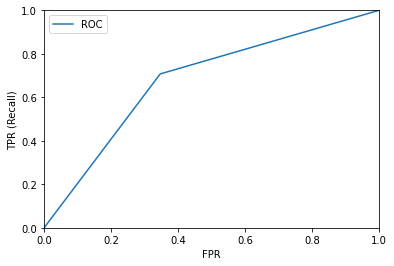

In [39]:
from sklearn.metrics import roc_curve
def roc_curve_plot(test_y, grid_pred):
    fprs, tprs, thresholds = roc_curve(test_y, grid_pred)
    
    plt.plot(fprs, tprs, label='ROC')
    
    start, end = plt.xlim()
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR')
    plt.ylabel('TPR (Recall)')
    plt.legend()
    plt.show()

roc_curve_plot(test_y, grid_pred)

## 2. Fill NA - median

In [40]:
# Split train and test data
from sklearn.model_selection import train_test_split

X = data_new.drop(['Potability'], axis=1)
y = data_new.Potability

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1)
train = pd.concat([train_X, train_y], axis=1)
test = pd.concat([test_X, test_y], axis=1)

# Classify each dataset by label

train_potable = train[train['Potability']==1]
train_notpotable = train[train['Potability']==0]
test_potable = test[test['Potability']==1]
test_notpotable = test[test['Potability']==0]

# Fill NA of ph with means
train_potable_ph_med = train_potable['ph'].median()
train_potable['ph'] = train_potable['ph'].fillna(train_potable_ph_med)
train_notpotable_ph_med = train_notpotable['ph'].median()
train_notpotable['ph'] = train_notpotable['ph'].fillna(train_notpotable_ph_med)
test_potable['ph'] = test_potable['ph'].fillna(train_potable_ph_med)
test_notpotable['ph'] = test_notpotable['ph'].fillna(train_notpotable_ph_med)

# fill NA of Sulfate
train_potable_SF_med = train_potable['Sulfate'].median()
train_potable['Sulfate'] = train_potable['Sulfate'].fillna(train_potable_SF_means)
train_notpotable_SF_med = train_notpotable['Sulfate'].median()
train_notpotable['Sulfate'] = train_notpotable['Sulfate'].fillna(train_notpotable_SF_med)
test_potable['Sulfate'] = test_potable['ph'].fillna(train_potable_SF_med)
test_notpotable['Sulfate'] = test_notpotable['ph'].fillna(train_notpotable_SF_med)

# Fill NA of Trihalomethanes
train_potable_TM_med = train_potable['Trihalomethanes'].median()
train_potable['Trihalomethanes'] = train_potable['Trihalomethanes'].fillna(train_potable_TM_med)
train_notpotable_TM_med = train_notpotable['Trihalomethanes'].median()
train_notpotable['Trihalomethanes'] = train_notpotable['Trihalomethanes'].fillna(train_potable_TM_med)
test_potable['Trihalomethanes'] = test_potable['Trihalomethanes'].fillna(train_potable_TM_med)
test_notpotable['Trihalomethanes'] = test_notpotable['Trihalomethanes'].fillna(train_notpotable_TM_med)

# 
train = pd.concat([train_potable, train_notpotable], axis=0)
test = pd.concat([test_potable, test_notpotable], axis=0)
print('train data의 NA 개수:', train.isna().sum())
print('test data의 NA 개수:', test.isna().sum())

#
train_X = train.drop(['Potability'], axis=1)
train_y = train.Potability
test_X = test.drop(['Potability'], axis=1)
test_y = test.Potability

train data의 NA 개수: ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64
test data의 NA 개수: ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


<ipython-input-40-f60033167634>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_potable['ph'] = train_potable['ph'].fillna(train_potable_ph_med)
<ipython-input-40-f60033167634>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_notpotable['ph'] = train_notpotable['ph'].fillna(train_notpotable_ph_med)
<ipython-input-40-f60033167634>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [41]:
train_s_X, train_s_y = sampling(train)

            ph    Hardness        Solids  Chloramines     Sulfate  \
3041  6.711815  232.206428  23936.275332     6.619088  333.583723   
2098  8.722311  145.246618  20256.353066    10.651998  333.583723   
2391  7.041030  152.537418  19731.749181    10.886742  373.988714   
1107  6.799376  239.057680   7986.493239    10.365680  419.881175   
1403  7.721033  203.354788  35800.699273     7.683399  312.919044   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
3041    463.510297       13.911879        78.190897   3.413647           0  
2098    612.327974       13.053340        94.826706   3.009289           0  
2391    463.747681       15.534904        61.151290   5.294159           1  
1107    373.232137       18.828594        43.440644   3.819985           1  
1403    424.966995       18.092608        96.442129   4.168487           0  


In [42]:
train_s_X, test_X = scaler_samples(train_s_X, test_X)

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
  
# define parameter search space
param_grid = {'n_estimators': [20, 50, 100, 200, 350, 500],
              'min_samples_leaf': [2, 10, 30],
              'max_features': ['auto', 'sqrt', 'log2'],
              'criterion': ['gini', 'entropy']} 
clf = RandomForestClassifier()
grid = GridSearchCV(clf, param_grid, refit = True, cv=5, verbose = 3, scoring='precision')
  
# fit the model for grid search
grid.fit(train_s_X, train_s_y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.874 total time=   0.2s
[CV 2/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.833 total time=   0.1s
[CV 3/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.857 total time=   0.2s
[CV 4/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.884 total time=   0.2s
[CV 5/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.864 total time=   0.1s
[CV 1/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=50;, score=0.845 total time=   0.4s
[CV 2/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=50;, score=0.837 total time=   0.4s
[CV 3/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=50;, score=0.886 total time=   0.4s
[

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 10, 30],
                         'n_estimators': [20, 50, 100, 200, 350, 500]},
             scoring='precision', verbose=3)

In [44]:
# print best parameters after grid search
print(grid.best_params_)
  
# print how the best model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 350}
RandomForestClassifier(criterion='entropy', max_features='log2',
                       min_samples_leaf=2, n_estimators=350)


In [45]:
grid_pred = grid.predict(test_X)
print("accuracy: %.2f" % accuracy(test_y, grid_pred))
print('precision score: ', precision_score(test_y,grid_pred))
print('f1 score: ', f1_score(test_y, grid_pred))

accuracy: 0.61
precision score:  0.4523809523809524
f1 score:  0.47500000000000003


## 3. Remove NA

In [46]:
data2 = data_new.dropna(axis=0)
X = data2.drop(['Potability'], axis=1)
y = data2.Potability

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1)

train = pd.concat([train_X, train_y], axis=1)

In [47]:
train_s_X, train_s_y = sampling(train)
train_s_X, test_X = scaler_samples(train_s_X, test_X)

            ph    Hardness        Solids  Chloramines     Sulfate  \
2593  7.539338  227.316128  12610.936307     9.507585  345.139235   
976   6.863136  194.586659  23610.517563     8.193416  346.768052   
1079  6.744799  204.084318  20215.697517     6.125252  304.527937   
481   5.903466  201.864032  25394.104720     7.692154  313.648072   
3033  7.104595  201.627117  18093.972162     8.474123  361.629187   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
2593    343.242711       12.769070        82.826282   5.114129           0  
976     439.229616       14.659741        89.027196   4.319777           0  
1079    544.339317       12.014243        72.608076   4.868543           1  
481     434.719747       18.006703        59.972160   4.587087           0  
3033    348.732937        8.582461        49.382684   4.763058           0  


In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
  
# define parameter search space
param_grid = {'n_estimators': [20, 50, 100, 200, 350, 500],
              'min_samples_leaf': [2, 10, 30],
              'max_features': ['auto', 'sqrt', 'log2'],
              'criterion': ['gini', 'entropy']} 
clf = RandomForestClassifier()
grid = GridSearchCV(clf, param_grid, refit = True, cv=5, verbose = 3, scoring='precision')
  
# fit the model for grid search
grid.fit(train_s_X, train_s_y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.780 total time=   0.3s
[CV 2/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.801 total time=   0.2s
[CV 3/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.795 total time=   0.3s
[CV 4/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.808 total time=   0.3s
[CV 5/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.817 total time=   0.3s
[CV 1/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=50;, score=0.798 total time=   0.6s
[CV 2/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=50;, score=0.824 total time=   0.7s
[CV 3/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=50;, score=0.797 total time=   0.7s
[

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 10, 30],
                         'n_estimators': [20, 50, 100, 200, 350, 500]},
             scoring='precision', verbose=3)

In [49]:
# print best parameters after grid search
print(grid.best_params_)
  
# print how the best model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 500}
RandomForestClassifier(min_samples_leaf=2, n_estimators=500)


In [50]:
grid_pred = grid.predict(test_X)
print("accuracy: %.2f" % accuracy(test_y, grid_pred))
print('precision score: ', precision_score(test_y,grid_pred))
print('f1 score: ', f1_score(test_y, grid_pred))

accuracy: 0.67
precision score:  0.6938775510204082
f1 score:  0.5074626865671642
